<a href="https://colab.research.google.com/github/BirukovAlex/neto_Python/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA_%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D1%8E_%C2%AB%D0%A1%D0%B8%D0%BD%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D0%B5%D0%BA%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%C2%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hankel, svd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Возьмём ряд с ярко-выраженной сезонностью - Пассажиры международных авиалиний

In [3]:
# 1. Загрузка данных
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
airlines_passengers.columns = ['Month', 'Passengers']
airlines_passengers['Month'] = pd.to_datetime(airlines_passengers['Month'])
airlines_passengers = airlines_passengers.set_index('Month')

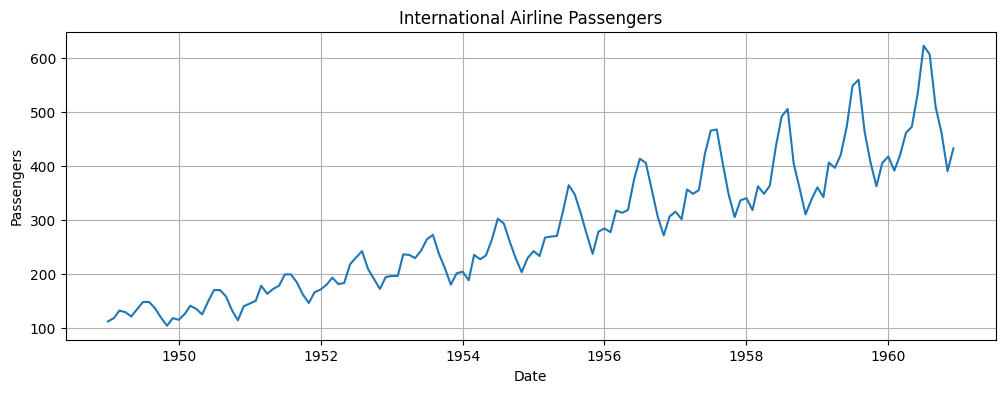

In [4]:
# Визуализация исходного ряда
plt.figure(figsize=(12, 4))
plt.plot(airlines_passengers['Passengers'])
plt.title('International Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

In [9]:
# Функция для SSA анализа
def ssa_analysis(series, window_size, n_components=None):
    if n_components is None:
        n_components = window_size

    # Создание траекторной матрицы
    N = len(series)
    K = N - window_size + 1
    X = hankel(series[:window_size], series[window_size-1:])

    # Визуализация траекторной матрицы
    plt.figure(figsize=(10, 8))
    plt.imshow(X, aspect='auto', cmap='viridis')
    plt.colorbar(label='Значение')
    plt.title(f'Траекторная матрица (L={window_size}, K={K})')
    plt.xlabel('Индекс столбца')
    plt.ylabel('Индекс строки')
    plt.tight_layout()
    plt.show()

    # SVD разложение
    U, s, VT = svd(X, full_matrices=False)

    # Реконструкция компонент
    components = []
    for i in range(min(n_components, len(s))):
        X_i = s[i] * np.outer(U[:, i], VT[i, :])
        # Диагональное усреднение
        reconstructed = np.array([np.mean([X_i[j, k-j] for j in range(max(0, k-K+1), min(window_size, k+1))])
                                for k in range(N)])
        components.append(reconstructed)

    return np.array(components), s, U

In [10]:
# Функция для расчета W-корреляций
def calculate_wcorrelation(components, window_size):
    """
    Расчет матрицы W-корреляций
    """
    n_components = components.shape[0]
    wcorr = np.zeros((n_components, n_components))
    N = components.shape[1]

    for i in range(n_components):
        for j in range(i, n_components):
            # Взвешенная корреляция
            weights = np.array([min(k+1, window_size, N-k) for k in range(N)])
            cov = np.sum(weights * components[i] * components[j])
            var_i = np.sum(weights * components[i]**2)
            var_j = np.sum(weights * components[j]**2)

            if var_i > 0 and var_j > 0:
                wcorr[i, j] = cov / np.sqrt(var_i * var_j)
                wcorr[j, i] = wcorr[i, j]
            else:
                wcorr[i, j] = 0
                wcorr[j, i] = 0

    return wcorr


=== Анализ с окном L=12 ===


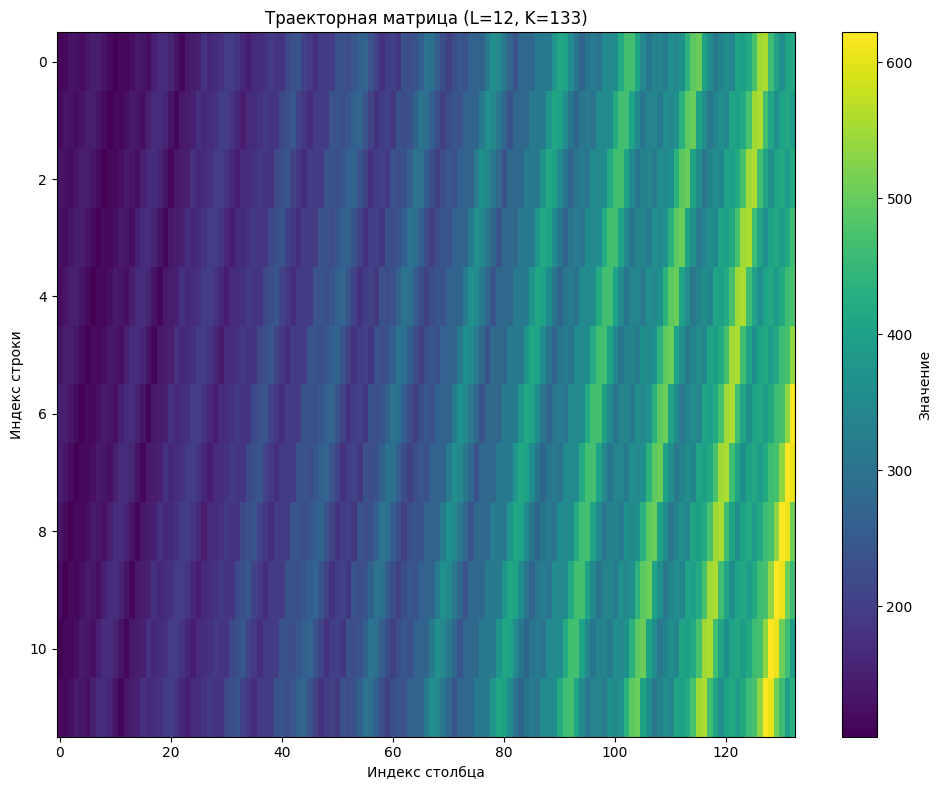

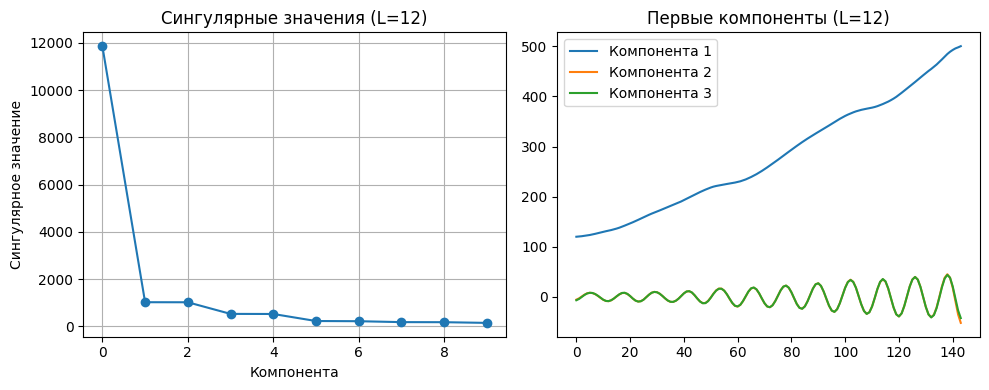


=== Анализ с окном L=24 ===


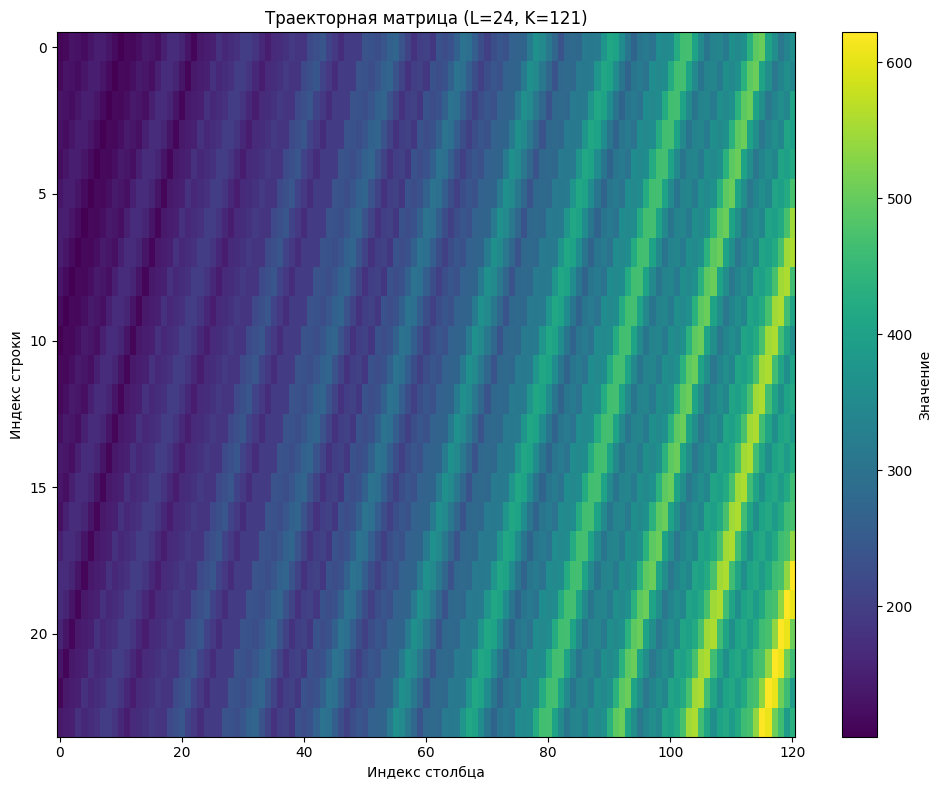

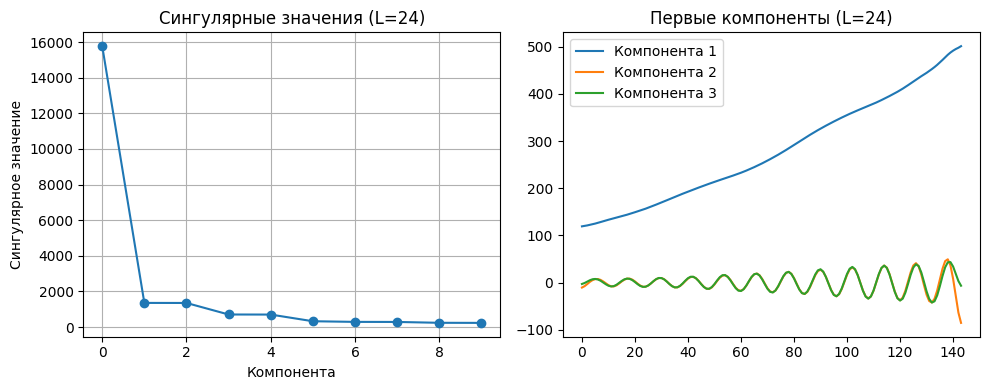


=== Анализ с окном L=36 ===


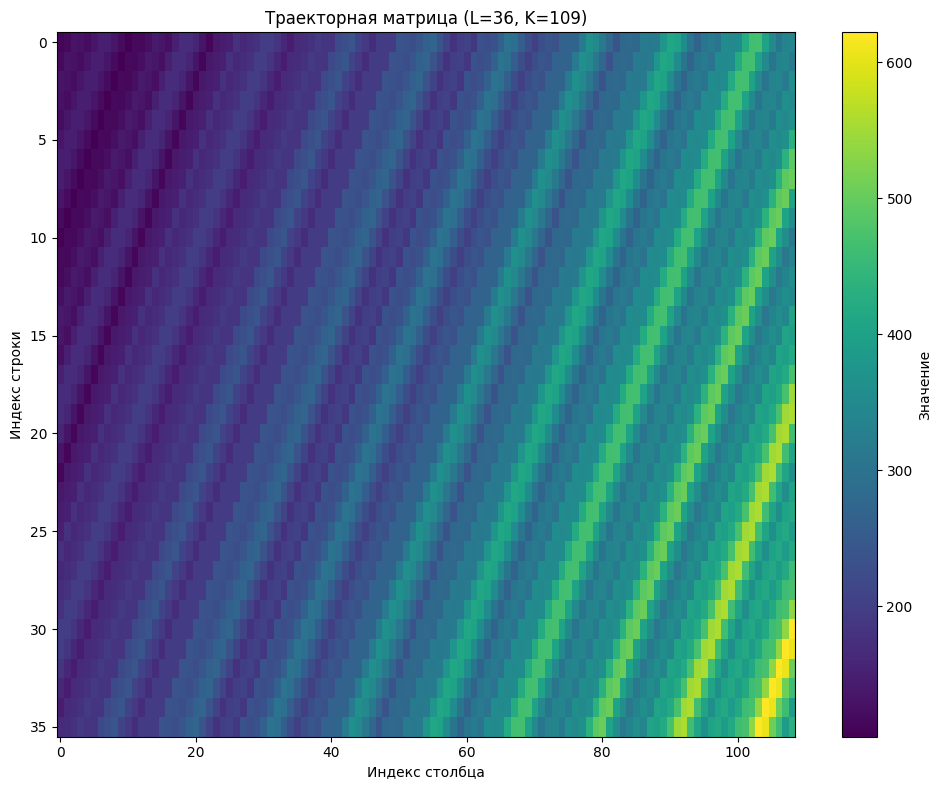

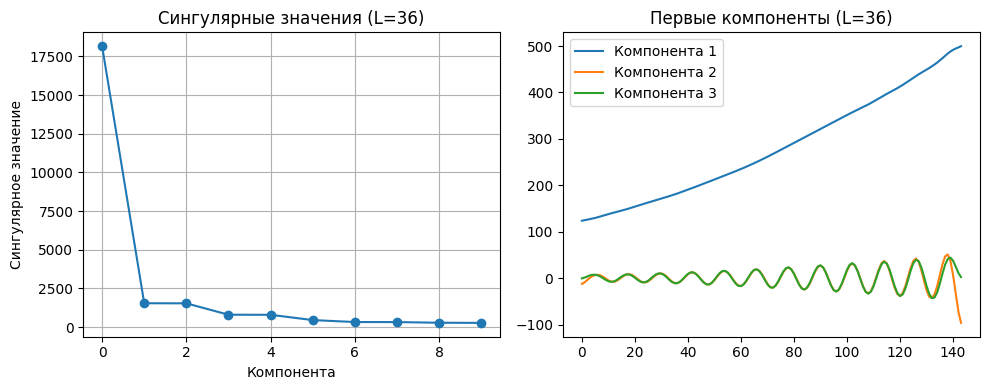

In [11]:
# 2. Анализ с разными длинами окон
window_sizes = [12, 24, 36]  # 1 год, 2 года, 3 года
series = airlines_passengers['Passengers'].values.astype(float)

results = {}

for L in window_sizes:
    print(f"\n=== Анализ с окном L={L} ===")

    # SSA разложение
    components, singular_values, U = ssa_analysis(series, L, n_components=10)
    results[L] = {
        'components': components,
        'singular_values': singular_values,
        'wcorr': calculate_wcorrelation(components, L)
    }

    # Визуализация сингулярных значений
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(singular_values[:10], 'o-')
    plt.title(f'Сингулярные значения (L={L})')
    plt.xlabel('Компонента')
    plt.ylabel('Сингулярное значение')
    plt.grid(True)

    # Визуализация первых компонент
    plt.subplot(1, 2, 2)
    for i in range(3):
        plt.plot(components[i], label=f'Компонента {i+1}')
    plt.title(f'Первые компоненты (L={L})')
    plt.legend()
    plt.tight_layout()
    plt.show()

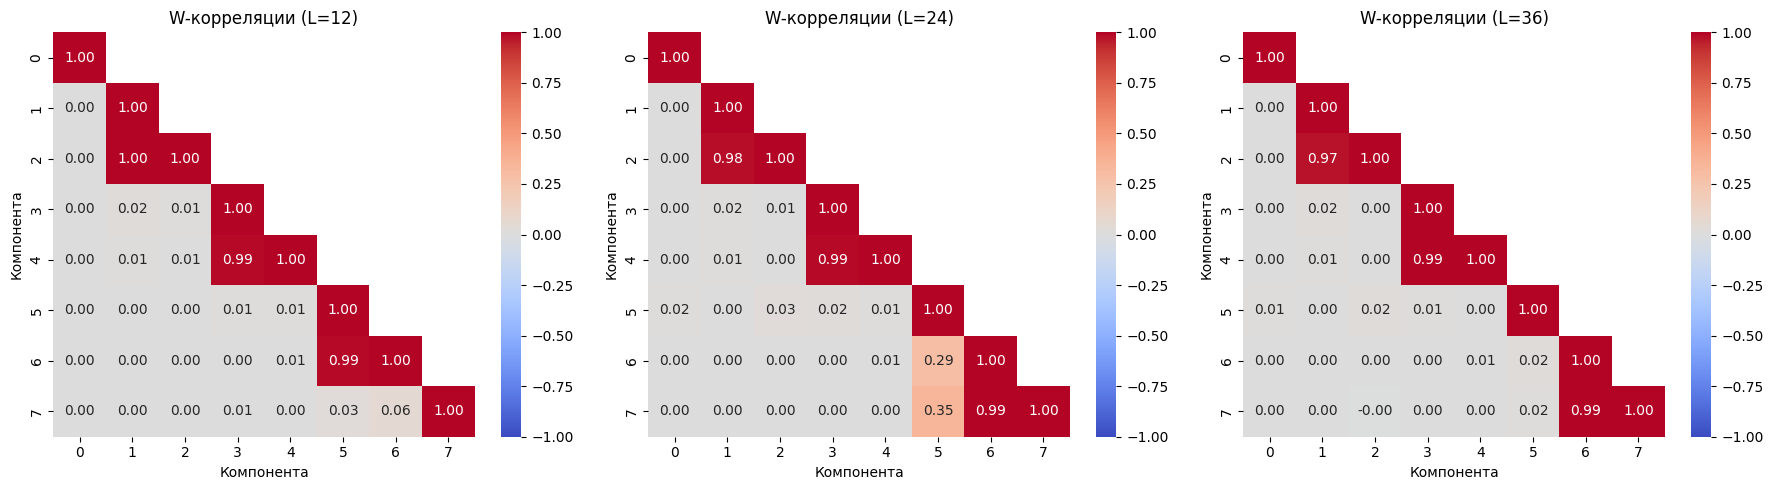

In [12]:
# 3. Матрицы W-корреляций для каждого размера окна
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, L in enumerate(window_sizes):
    wcorr = results[L]['wcorr']

    # Ограничиваем для лучшей визуализации
    n_show = min(8, wcorr.shape[0])
    mask = np.triu(np.ones_like(wcorr[:n_show, :n_show]), k=1)

    sns.heatmap(wcorr[:n_show, :n_show],
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                center=0,
                vmin=-1, vmax=1,
                mask=mask,
                ax=axes[idx])
    axes[idx].set_title(f'W-корреляции (L={L})')
    axes[idx].set_xlabel('Компонента')
    axes[idx].set_ylabel('Компонента')

plt.tight_layout()
plt.show()

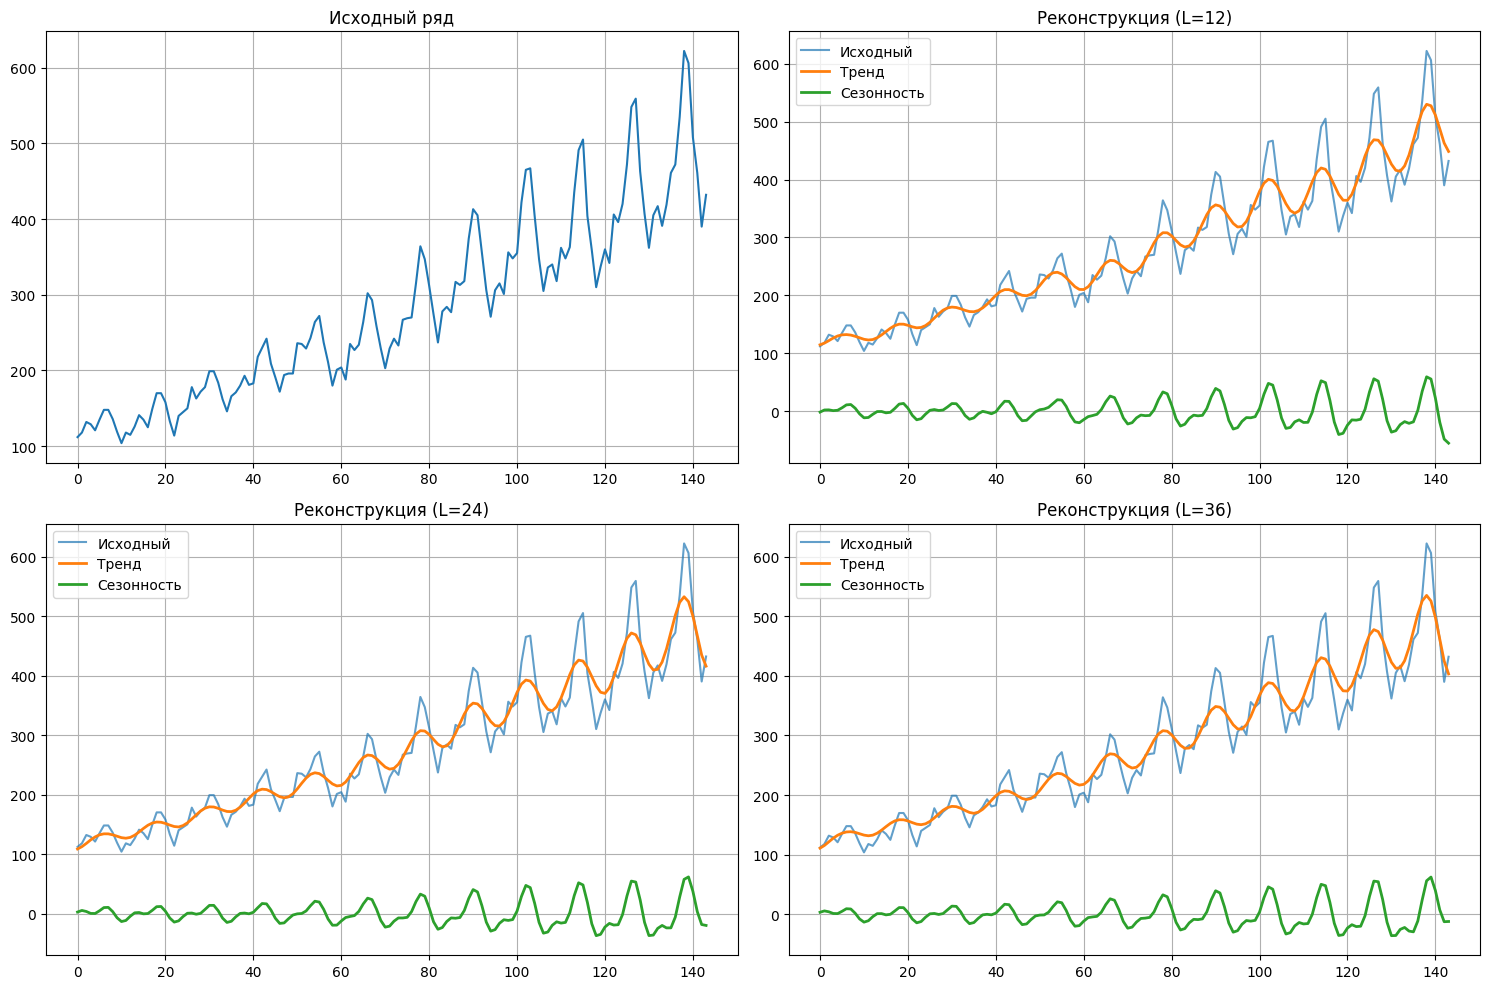

In [14]:
# 4. Сравнение реконструкций
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Исходный ряд
axes[0, 0].plot(series)
axes[0, 0].set_title('Исходный ряд')
axes[0, 0].grid(True)

# Реконструкции с разными окнами
for idx, L in enumerate(window_sizes):
    components = results[L]['components']

    # Реконструкция тренда (первые 2 компоненты)
    trend_reconstruction = np.sum(components[:2], axis=0)

    # Реконструкция сезонности (следующие 2 компоненты)
    if components.shape[0] >= 4:
        seasonal_reconstruction = np.sum(components[2:4], axis=0)
    else:
        seasonal_reconstruction = np.zeros_like(trend_reconstruction)

    row = (idx + 1) // 2
    col = (idx + 1) % 2

    axes[row, col].plot(series, alpha=0.7, label='Исходный')
    axes[row, col].plot(trend_reconstruction, label='Тренд', linewidth=2)
    axes[row, col].plot(seasonal_reconstruction, label='Сезонность', linewidth=2)
    axes[row, col].set_title(f'Реконструкция (L={L})')
    axes[row, col].legend()
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Количественное сравнение
print("\n=== КОЛИЧЕСТВЕННОЕ СРАВНЕНИЕ ===")
for L in window_sizes:
    components = results[L]['components']

    # Полная реконструкция (первые 6 компонент)
    full_reconstruction = np.sum(components[:6], axis=0)

    # Ошибка реконструкции
    mse = np.mean((series - full_reconstruction)**2)

    # Доля объясненной дисперсии
    total_variance = np.var(series)
    explained_variance = 1 - (mse / total_variance)

    print(f"Окно L={L}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  Объясненная дисперсия: {explained_variance:.3f}")
    print(f"  Сингулярные значения: {results[L]['singular_values'][:3]}")


=== КОЛИЧЕСТВЕННОЕ СРАВНЕНИЕ ===
Окно L=12:
  MSE: 87.34
  Объясненная дисперсия: 0.994
  Сингулярные значения: [11857.41765183  1026.35220484  1024.27504789]
Окно L=24:
  MSE: 132.64
  Объясненная дисперсия: 0.991
  Сингулярные значения: [15769.77803747  1352.80207502  1349.97141981]
Окно L=36:
  MSE: 155.92
  Объясненная дисперсия: 0.989
  Сингулярные значения: [18159.160093    1542.04269278  1535.57085377]


In [16]:
# Анализ разделимости компонент
print("\n=== АНАЛИЗ РАЗДЕЛИМОСТИ КОМПОНЕНТ ===")
for L in window_sizes:
    wcorr = results[L]['wcorr']
    # Средняя корреляция между первыми 4 компонентами
    mask = np.triu(np.ones((4, 4)), k=1)
    avg_corr = np.mean(wcorr[:4, :4][mask == 1])
    print(f"L={L}: Средняя корреляция между первыми 4 компонентами = {avg_corr:.3f}")


=== АНАЛИЗ РАЗДЕЛИМОСТИ КОМПОНЕНТ ===
L=12: Средняя корреляция между первыми 4 компонентами = 0.172
L=24: Средняя корреляция между первыми 4 компонентами = 0.167
L=36: Средняя корреляция между первыми 4 компонентами = 0.167


Выводы:
- L=12: Лучшее качество реконструкции (MSE=87.34), но худшая разделимость (0.172)
- L=24: Хорошее качество (MSE=132.64) + лучшая разделимость (0.167)
- L=36: Худшее качество (MSE=155.92) + лучшая разделимость (0.167)
Лучшая разделимость означает более чистые и интерпретируемые компоненты.


Не нравится разрыв MSE в 45 единиц с L12 (ухудшение на ~51%)

Мой выбор - L12, а окно L24 только если критически важна разделимость.